In [ ]:
from google.colab import files
files.upload()

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d srbhshinde/flickr8k-sau

100% 2.07G/2.08G [00:23<00:00, 54.2MB/s]
100% 2.08G/2.08G [00:23<00:00, 96.4MB/s]


In [ ]:
!unzip /content/flickr8k-sau.zip

In [4]:
!pwd

/content


In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
import pathlib
data_dir = pathlib.Path('/Flickr_Data/Images')

In [4]:
data_dir ='/content/Flickr_Data/Images/**/*.jpg'

In [6]:
import glob

In [5]:
list(glob.glob(data_dir,recursive=True))[:5]

['/content/Flickr_Data/Images/1335617803_4fbc03dab0.jpg',
 '/content/Flickr_Data/Images/2895403073_906768cafa.jpg',
 '/content/Flickr_Data/Images/2124040721_bffc0a091a.jpg',
 '/content/Flickr_Data/Images/201682811_105241dee3.jpg',
 '/content/Flickr_Data/Images/1248357227_2b4175fc39.jpg']

In [6]:
image_count =len(list(glob.glob(data_dir,recursive=True)))
image_count

8091

In [9]:
import cv2
import PIL
images= list(glob.glob(data_dir,recursive=True))

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [11]:
from keras.applications import ResNet50
import_model = ResNet50(include_top=True)

In [ ]:
import_model.summary()

In [ ]:
from keras.models import Model
last_layer = import_model.layers[-2].output
modele = Model(inputs= import_model.input,outputs=last_layer)
modele.summary()

In [ ]:


images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 1499:
        break
        
    elif count % 50 == 0:
        print(count)
    
        
  


In [82]:
modele.save('resent.h5')
files.download('resent.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Text Processing

In [ ]:
token_path = '/content/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
captions = open(token_path,'rb').read().decode('utf-8').split('\n')
captions

In [ ]:
print(captions[1])# due to print it make \t as tab
print(captions[1].split('\t'))
print(captions[1].split('\t')[0])
#whole string excpet last 2 digit
print(captions[1].split('\t')[0][:-2])

In [19]:
print(captions[1].split('\t')[1])

A girl going into a wooden building .


In [38]:
#every image has 5 caption
captions_dict = {}
try:
  for i in captions:
    img_name = i.split('\t')[0][:-2]
    caption_name = i.split('\t')[1]
    if img_name in images_features:
      if img_name not in captions_dict:
        captions_dict[img_name] = [caption_name]
      else:
        captions_dict[img_name].append(caption_name)
except:
  print(img_name,i)
  pass

In [ ]:
captions_dict

In [40]:
def processed_text(txt):
  modified = txt.lower()
  modified ='startofseq ' + modified + ' endofseq'
  return modified

In [41]:
for key,value in captions_dict.items():
  for i in value:
    captions_dict[key][value.index(i)] = processed_text(i)

In [42]:
# every word in giving them indices
count_word={}#voculablary
count =1
#value is list of caption and key is image name
for key, value in captions_dict.items():
  for sentence in value:
    for word in sentence.split():
      if word not in count_word:
        count_word[word] = count
        count +=1

In [43]:
len(count_word)

3907

In [44]:
count_word
captions_dict2 = captions_dict.copy()

In [45]:
for k, value in captions_dict.items():
  for lst in value:
    encoded =[]
    for word in lst.split():
      encoded.append(count_word[word])

    captions_dict2[k][value.index(lst)]=encoded


In [46]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [ ]:
MAX_LEN =0
for key,value in captions_dict2.items():
  for sentence in value:
    if len(sentence) > MAX_LEN:
      MAX_LEN= len(sentence)
      print(sentence)

MAX_LEN

In [ ]:
len(count_word)

In [49]:
VOCAB_SIZE =len(count_word)


def generator(img_dict,caption_dict):
  n_samples = 0
  X= []
  y_in =[]
  y_out =[]

  for key,value in caption_dict.items():
    for v in value:
      for i in range(1,len(v)):
        X.append(img_dict[key])

        #alll sequence from 0 to i-1== [[0:1],[0:2],...]
        in_seq = [v[:i]]
        #last  word i
        out_seq = v[i]

        #post = last
        in_seq = pad_sequences(in_seq , maxlen=MAX_LEN,padding='post',truncating='post')[0]
        # out_seq will be like where the word is it will be 1 and other places it will be 0 and the size of this list is = VOCAB_SIZE
        out_seq = to_categorical([out_seq],num_classes=VOCAB_SIZE+1)[0]
        y_in.append(in_seq)
        y_out.append(out_seq)

  return X,y_in,y_out

In [50]:
X,y_in,y_out = generator(images_features,captions_dict2)


In [51]:
len(X),len(y_in),len(y_out)

(95300, 95300, 95300)

In [52]:
import numpy as np
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [53]:
X.shape,y_in.shape,y_out.shape

((95300, 2048), (95300, 40), (95300, 3908))

# Final Model


In [54]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

In [ ]:
embedding_size= 128
max_len = MAX_LEN
vocab_size = len(count_word)+1
#4380

image_model = Sequential()
image_model.add(Dense(128,input_shape=(2048,),activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

In [ ]:
caption_model = Sequential()
caption_model.add(Embedding(input_dim=vocab_size,output_dim=128,input_length=max_len))
#bi lstm
caption_model.add(LSTM(256, return_sequences=True))
caption_model.add(TimeDistributed(Dense(embedding_size)))

caption_model.summary()


In [ ]:
conca = Concatenate()([image_model.output, caption_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, caption_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit([X, y_in], y_out, batch_size=512, epochs=70)

In [ ]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

In [78]:
inv_dict = {v:k for k, v in count_word.items()}

In [64]:
model.save('model.h5')
from google.colab import files
files.download('model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
model.save_weights('mine_model_weights.h5')
files.download('mine_model_weights.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
np.save('vocab.npy', count_word)
files.download('vocab.npy') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

In [75]:
test_fetaure = modele.predict(getImage(2500)).reshape(1,2048)

In [76]:
test_fetaure

array([[0.89159185, 1.376007  , 0.60003716, ..., 0.0163272 , 0.23478769,
        0.27963325]], dtype=float32)

In [ ]:
test_img_path = images[2500]

PIL.Image.open(test_img_path)

In [ ]:
count_word

In [79]:
text_inp = ['startofseq']

count = 0
caption = ''
while count < 25:
    count += 1

    encoded = []
    for i in text_inp:
        encoded.append(count_word[i])

    encoded = [encoded]

    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


    prediction = np.argmax(model.predict([test_fetaure, encoded]))

    sampled_word = inv_dict[prediction]

    caption = caption + ' ' + sampled_word
        
    if sampled_word == 'endofseq':
        break

    text_inp.append(sampled_word)





In [ ]:
import matplotlib.pyplot as plt
plt.figure()

PIL.Image.open(test_img_path)


In [ ]:
PIL.Image.open(test_img_path)

In [ ]:
model_for_image.save('model_for_image.h5')

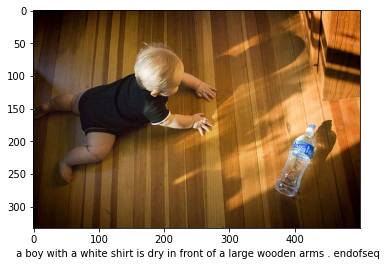

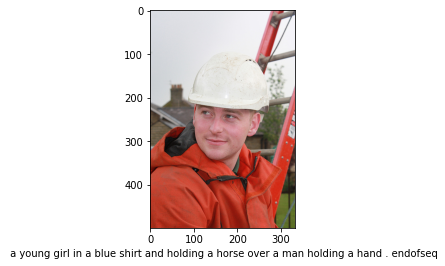

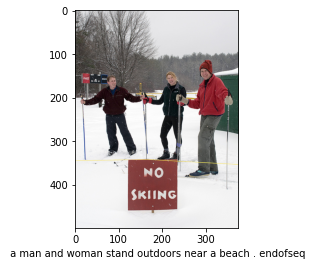

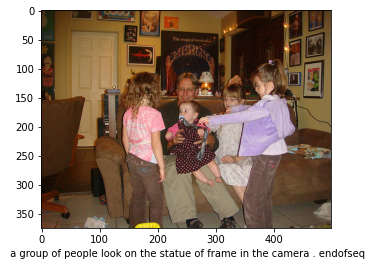

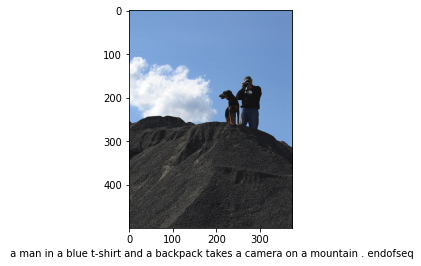

In [81]:
for i in range(5):
    
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    
    
    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(count_word[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word
            
        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)